In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [3]:
def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1 ,1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Show the training samples

In [5]:
# print('features:', features[0], '\nlabel:', labels[0])
indx = list(range(len(features)))
features[torch.tensor(indx[0:5])]

tensor([[-1.0140, -0.2560],
        [-0.3307,  1.4382],
        [-0.6579,  1.3188],
        [-0.1599,  0.0640],
        [ 1.3845,  0.0024]])

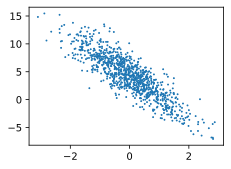

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

In [7]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))

    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor([indices[i:min(i +
                                                    batch_size,
                                                    num_examples)]])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[[ 0.8968, -1.4624],
         [-0.8817,  1.7174],
         [ 0.8707,  0.5821],
         [-0.8000, -0.0696],
         [-0.7495,  1.8073],
         [ 0.2108, -1.7939],
         [-0.8005,  2.7617],
         [-0.0561, -0.4367],
         [-1.4985, -0.5317],
         [ 0.6693,  1.5464]]]) 
 tensor([[[10.9802],
         [-3.4151],
         [ 3.9735],
         [ 2.8497],
         [-3.4403],
         [10.7027],
         [-6.7977],
         [ 5.5681],
         [ 2.9874],
         [ 0.2704]]])


定义模型

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

计算均方损失 $MSE=\frac{1}{2n}\sum_{i=1}^{n}(y_i-\hat{y_i})^2$

In [9]:
def square_loss(y_hat, y):
    return (y.reshape(y_hat.shape) - y_hat)**2 / 2

随机梯度下降SGD\
这里的 with torch.no_grad() 代表不需要计算梯度

In [10]:
def sgd(params, lr, batch_size):
    """实现小批量梯度下降
    这里只实现了通过学习率使用梯度更新参数的式子，没有进行梯度计算
    因此用了with torch.no_grad()表示不需要进行梯度计算
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 梯度清零(这里在使用梯度进行迭代后)

训练过程\
模型收敛

In [12]:
lr = 0.01
num_epochs = 15
net = linreg
loss = square_loss

w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        """
        这里net(X, w, b)得到一个维度为batch_size的一维向量y hat
        这里的loss返回的是一个维度为batch_size的向量
        """
        l = loss(net(X, w, b), y)
        
        # 因为'l'形状是('batch_size', 1)，而不是一个标量
        l.sum().backward()
        # backward()自动给w.grad和b.grad赋值
        # 因此在sgd函数中不需要求梯度，因此调用了with torch.no_grad()语句
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch}, train loss: {train_l.mean():f}')

epoch 0, train loss: 2.256172
epoch 1, train loss: 0.312482
epoch 2, train loss: 0.043535
epoch 3, train loss: 0.006141
epoch 4, train loss: 0.000908
epoch 5, train loss: 0.000173
epoch 6, train loss: 0.000069
epoch 7, train loss: 0.000055
epoch 8, train loss: 0.000053
epoch 9, train loss: 0.000052
epoch 10, train loss: 0.000052
epoch 11, train loss: 0.000052
epoch 12, train loss: 0.000052
epoch 13, train loss: 0.000052
epoch 14, train loss: 0.000052


In [13]:
print(f'The true error of w: {true_w - w.reshape(true_w.shape)}')
print(f'The true error of b: {true_b - b}')

The true error of w: tensor([0.0002, 0.0007], grad_fn=<SubBackward0>)
The true error of b: tensor([-0.0002], grad_fn=<RsubBackward1>)
